# **OTC:** Overhead Time Calculator

This report presents the Overhead Time Calculator (OTC) methodology and results. It details the data preparation process, the model used to estimate slew times, and provides an example based on a specific night's data.

In [ ]:
import pandas as pd
from ttt.elasticsearch import client as es
import json
import numpy as np
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy.time import Time
import astropy.units as u

### Querying Dataset from ElasticSearch

ElasticSearch is a distributed, RESTful search and analytics engine renowned for its ability to index, search, and analyze vast volumes of data quickly and in near real-time. In the context of telescope operations, the ElasticSearch database under consideration houses the logs of not just the telescope itself, but also of all the components and subsystems that play a part in its operation. Such comprehensive logging is crucial, as telescopes are complex machines with numerous moving parts, software interfaces, and auxiliary systems. Monitoring the performance, behavior, and interactions of these elements is essential for ensuring optimal functioning, diagnosing issues, and conducting preventive maintenance.

The following function is designed to extract logging information for a specific telescope over a given time span. The significance of this function arises from the need to monitor and review the operational logs of telescopes, which can provide insights into their performance, anomalies, or any noteworthy events that occur during observations.

In [ ]:


def query_telescope_logs(telescope, date_from, date_to):
    """
    Queries all logging information of a given telescope within a specific timestamp range.
    
    Parameters:
    - telescope (str): Name/Identifier of the telescope.
    - date_from (str): Start date/time in the format 'YYYY-MM-DDTHH:mm:ss'.
    - date_to (str): End date/time in the format 'YYYY-MM-DDTHH:mm:ss'.
    
    Returns:
    - DataFrame: A DataFrame containing the logging information.
    """

    body = {
        "track_total_hits": True,
        "sort": [
            {
                "@timestamp": {
                    "order": "desc",
                    "unmapped_type": "boolean"
                }
            }
        ],
        "size": 10000,  # adjust size as needed
        "_source": ["@timestamp", "message", "extra.*"],  # adjust fields as needed
        "query": {
            "bool": {
                "must": [
                    {
                        "match_phrase": {
                            "extra.telescope": telescope
                        }
                    },
                    {
                        "range": {
                            "@timestamp": {
                                "format": "strict_date_optional_time",
                                "gte": date_from,
                                "lte": date_to
                            }
                        }
                    }
                ]
            }
        }
    }
    
    # Initial search with scroll window set
    res = es.search(index='logstash', body=body, scroll='1m')

    data = [hit['_source'] for hit in res['hits']['hits']]

    # Continue "scrolling" as long as there are more results
    while len(res['hits']['hits']):
        res = es.scroll(scroll_id=res['_scroll_id'], scroll='1m')
        data.extend([hit['_source'] for hit in res['hits']['hits']])
        
    # Clear the scroll when done
    es.clear_scroll(body={'scroll_id': res['_scroll_id']})

    df = pd.DataFrame(data)
    df = df[['@timestamp', 'message']]
    df.rename(columns={'@timestamp': 'timestamp'}, inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.sort_values(by='timestamp', inplace=True)
    return df

For the telescope labeled 'TTT1', a specific set of logs has been queried for the period starting from July 28, 2023, at 18:00:00 and ending on July 29, 2023, at 08:00:00. The aim is to scrutinize the operational records within this timeframe, which could shed light on the telescope's behavior, any anomalies, or specific events of interest during these hours.

In [ ]:
telescope = 'TTT1'
date_from = '2023-07-28T18:00:00'
date_to = '2023-07-29T08:00:00'

df = query_telescope_logs(telescope, date_from, date_to)

/tmp/ipykernel_21252/1964195193.py:49: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(index='logstash', body=body, scroll='1m')
/tmp/ipykernel_21252/1964195193.py:59: DeprecationWarning: The 'body' parameter is deprecated for the 'clear_scroll' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.clear_scroll(body={'scroll_id': res['_scroll_id']})


In [ ]:
# Data inspection
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27510 entries, 27509 to 0
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  27510 non-null  datetime64[ns, UTC]
 1   message    27510 non-null  object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 644.8+ KB
None


Upon fetching these logs, an initial inspection is performed to understand the structure and content of the data. The dataset primarily consists of two columns:

1. **timestamp**: This column denotes the exact moment when a particular log message was received. It is instrumental in tracing the chronological sequence of events or understanding the timing of specific operations or anomalies.
2. **message**: This column contains the actual log messages, detailing the operations, events, or potential issues related to the telescope.

In [ ]:
df

,timestamp,message
27509,2023-07-28 18:00:18.418000+00:00,sensor temperature is 0.1 degrees and cooler P...
27508,2023-07-28 18:00:18.421000+00:00,(True) server accepting connections...
27507,2023-07-28 18:00:48.453000+00:00,sensor temperature is 0.2 degrees and cooler P...
27506,2023-07-28 18:00:48.457000+00:00,(True) server accepting connections...
27505,2023-07-28 18:01:18.489000+00:00,sensor temperature is 0.2 degrees and cooler P...
...,...,...
4,2023-07-29 07:57:54.343000+00:00,(True) server accepting connections...
3,2023-07-29 07:58:24.378000+00:00,(True) server accepting connections...
2,2023-07-29 07:58:54.412000+00:00,(True) server accepting connections...
1,2023-07-29 07:59:24.447000+00:00,(True) server accepting connections...


To pinpoint specific events, a filter is applied to the dataset to identify instances where the telescope was "performing observation." This helps in understanding when the telescope started a new observation. The timestamps corresponding to these events are then extracted, providing a precise record of when the controller received the command and started moving the elements.

In [ ]:
start_perform_observation = df[df['message'].str.contains("performing observation")]['timestamp']
start_perform_observation

26850   2023-07-28 21:28:00.347000+00:00
25882   2023-07-28 21:28:41.379000+00:00
25657   2023-07-28 21:29:19.150000+00:00
24323   2023-07-28 21:33:27.421000+00:00
22833   2023-07-28 21:36:58.646000+00:00
20999   2023-07-28 21:53:39.826000+00:00
19905   2023-07-28 21:54:33.019000+00:00
19657   2023-07-28 21:55:26.731000+00:00
19029   2023-07-28 22:36:11.165000+00:00
17922   2023-07-28 22:37:05.221000+00:00
17689   2023-07-28 22:37:59.810000+00:00
16053   2023-07-28 22:42:13.616000+00:00
14721   2023-07-29 00:07:29.639000+00:00
12963   2023-07-29 00:25:17.952000+00:00
11263   2023-07-29 00:50:10.187000+00:00
8758    2023-07-29 01:41:46.382000+00:00
7771    2023-07-29 01:45:07.133000+00:00
6604    2023-07-29 02:16:57.200000+00:00
4956    2023-07-29 03:14:43.149000+00:00
4006    2023-07-29 03:32:45.266000+00:00
2877    2023-07-29 03:59:46.041000+00:00
1854    2023-07-29 04:29:17.787000+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

### Computing Overheads for Telescope Observations

Overheads can arise from various processes: the time taken for the telescope to slew to a new position, the time taken to change a filter, the time delay between sending a command and its actual execution, and more.

The following function is engineered to extract and calculate these overheads from the logs of telescope operations. It determines the overheads by comparing the time logs of specific events like starting an observation and the actual commencement of data collection.

Key features and computations of the function:

1. **Observation Start Time**: The function identifies the timestamps when the telescope begins its observation routine.
2. **Real Observation Begin (Exposition) Time**: It then pinpoints the exact moment when the telescope starts its actual data collection, marking the beginning of an observation block.
3. **Exposure Time**: Within the logs, there's a command that specifies the exposure time of the following Observing Block. This is needed to account for the first frame issue reported in QHY cameras.
4. **Mount Slewing Time**: Slewing refers to the movement from one position in the sky to another. The function calculates the time taken for this movement by comparing the time the coordinates were sent to the mount and when the mount confirmed its readiness.
5. **Filter Wheel Time**: The time taken to change from one filter to another can contribute to overheads.
6. **RA and DEC Extraction**: For every observation, the function extracts the Right Ascension (RA) and Declination (DEC) – the two key coordinates that define the position of a celestial object in the sky.

The function then compiles all these metrics into a DataFrame, providing a structured view of overheads and other parameters for each observation block. 

In [ ]:
teide_location = EarthLocation(lat=28.3000*u.deg, lon=-16.5100*u.deg, height=2390*u.m)

def get_info_from_log(df):
    
    start_perform_observation = df[df['message'].str.contains("performing observation")]['timestamp']

    # Find real OB start time
    starting_exposition_times = df[df['message'].str.contains("starting exposition")]['timestamp']
    starting_exposition_times = pd.to_datetime(starting_exposition_times)

    exposure_times = []
    overheads = []
    ras, decs = [], []

    slewing_times = []
    filterwheel_times = []
    previous_filter_positions = []
    actual_filter_positions = []


    for i,observation_time in enumerate(start_perform_observation):

        # Find the next "starting exposition" time after the current "performing observation" time
        next_exposition_time = starting_exposition_times[starting_exposition_times > observation_time].iloc[0]
        overhead = next_exposition_time - pd.to_datetime(observation_time)
        overheads.append(overhead)
        
        # Filter the messages between "performing observation" and "starting exposition" to find the "set_exposition_time" command
        filtered_messages = df[(df['timestamp'] > observation_time) & (df['timestamp'] < next_exposition_time)]
        exposition_message = filtered_messages[filtered_messages['message'].str.contains("set_exposition_time")]['message'].iloc[0]
        
        # Extract the exposure time from the message
        exposure_time = float(exposition_message.split("set_exposition_time ")[1].split(" ")[0])
        exposure_times.append(exposure_time)

        ######
        # Mount slewing + de-rotator time
        ######
        
        # Identify the "telescope actual coordinates..." message and extract the RA and DEC
        coordinates_message = filtered_messages[filtered_messages['message'].str.contains("telescope actual coordinates sent to mount")]['message'].iloc[0]
        ra, dec = coordinates_message.split("will be jnow ")[1].split(":")
        ras.append(float(ra)*15)
        decs.append(float(dec))

        
        # Find the timestamp of the above message and the timestamp of the "mount is ready" message
        coordinates_timestamp = filtered_messages[filtered_messages['message'].str.contains("telescope actual coordinates sent to mount")]['timestamp'].iloc[0]
        mount_ready_timestamp = filtered_messages[filtered_messages['message'].str.contains("mount is ready")]['timestamp'].iloc[0]
        
        # Calculate the slewing time
        slewing_time = mount_ready_timestamp - coordinates_timestamp
        slewing_times.append(slewing_time.total_seconds())

        ######
        # Filter wheel time
        ######

        # Extract filter change time and actual filter position
        start_filterwheel_messages = filtered_messages[filtered_messages['message'].str.contains("filterwheel changed async to position")]
        end_filterwheel_messages = filtered_messages[filtered_messages['message'].str.contains("filterwheel in position")]
        
        if not start_filterwheel_messages.empty and not end_filterwheel_messages.empty:
            start_filterwheel_message = start_filterwheel_messages['timestamp'].iloc[0]
            end_filterwheel_message = end_filterwheel_messages['timestamp'].iloc[0]
            actual_position = int(end_filterwheel_messages['message'].iloc[0].split("position ")[1])
            filter_change_time = (end_filterwheel_message - start_filterwheel_message).total_seconds()
        else:
            filter_change_time = 0
            actual_position = None
        
        # Extract previous filter position
        previous_messages = df[df['timestamp'] < observation_time]
        most_recent_filter_message = previous_messages[previous_messages['message'].str.contains("filterwheel in position")]
        
        if not most_recent_filter_message.empty:
            previous_position = int(most_recent_filter_message['message'].iloc[-1].split("position ")[1])
        else:
            previous_position = 0 if actual_position is not None else None
        
        if actual_position is None: actual_position = previous_position


        # Append extracted details to lists
        filterwheel_times.append(filter_change_time)
        previous_filter_positions.append(previous_position)
        actual_filter_positions.append(actual_position)

    # Recalculate the total overheads (previous overhead + exposure time) for each observation
    total_overheads = [(overhead + pd.Timedelta(seconds=exposure_time)).total_seconds() for overhead, exposure_time in zip(overheads, exposure_times)]



    df_times = pd.DataFrame({'OB_start_time': start_perform_observation,
                            'total_overhead': total_overheads,
                            'slewing_time': slewing_times,
                            'first_frame_time': exposure_times,
                            'filter_change_time': filterwheel_times,
                            'actual_ra': ras,
                            'actual_dec': decs,
                            'prev_filter_pos': previous_filter_positions,
                            'actual_filter_pos': actual_filter_positions})


    df_times = df_times.reset_index(drop=True)

    return df_times

In [ ]:
df_times = get_info_from_log(df)
df_times

,OB_start_time,total_overhead,slewing_time,first_frame_time,filter_change_time,actual_ra,actual_dec,prev_filter_pos,actual_filter_pos
0,2023-07-28 21:28:00.347000+00:00,27.390545,19.434,6.481545,1.777,211.119662,54.203854,0,1
1,2023-07-28 21:28:41.379000+00:00,12.245028,3.317,8.155028,1.331,211.119663,54.203854,1,2
2,2023-07-28 21:29:19.150000+00:00,58.561815,25.437,32.370815,4.843,229.936599,1.996545,2,1
3,2023-07-28 21:33:27.421000+00:00,53.472610,25.074,27.627610,4.838,193.348910,85.007165,3,2
4,2023-07-28 21:36:58.646000+00:00,51.511536,24.515,26.234536,3.622,271.376699,55.737921,2,0
5,2023-07-28 21:53:39.826000+00:00,32.706729,24.547,6.612729,1.887,211.119684,54.203853,0,1
6,2023-07-28 21:54:33.019000+00:00,12.296085,3.230,8.302085,1.333,211.119684,54.203853,1,2
7,2023-07-28 21:55:26.731000+00:00,65.416824,24.650,39.994824,0.000,270.146167,51.001095,2,2
8,2023-07-28 22:36:11.165000+00:00,30.615384,22.114,6.928384,0.000,211.119719,54.203856,1,1
9,2023-07-28 22:37:05.221000+00:00,12.219929,2.834,8.636929,1.335,211.119720,54.203856,1,2


### Addressing Cable Wrap in Alt-Azimuth Mounts for TTT's AZ800 Telescopes

Alt-azimuth mounts, commonly used in observational astronomy, move in two axes: altitude (up and down) and azimuth (side to side). Their straightforward operation makes them suitable for many telescope setups. However, one challenge with such mounts is cable wrap. As the telescope slews around its azimuth axis, cables connected to the instrument can get twisted, potentially causing damage or hindering movement.

For the AZ800 telescopes operated by TTT, there's a predefined azimuthal limit set at $\pm225^\circ$ from the southern cardinal point (AZ = 180) to prevent excessive cable wrapping. This configuration, as defined by the manufacturer's original software, means that if the telescope's pointing is about to surpass this limit, it doesn't follow the shortest path. Instead, it takes the longer way around, increasing the slewing time and thus the overhead.

Understanding and managing this behavior is crucial, especially when planning observations.

The initial positioning at the start of a night, after taking sky flats, is AZ = 90 (East) and ALT = 70, with a cable rotation of -90.

The following function aims to address this challenge by augmenting the dataset with information regarding the mount's position and the state of cable rotation.

Key features of the function:

1. **Coordinate Transformations**: Two helper functions, `altaz_from_radec` and `radec_from_altaz`, are defined to transform between the Equatorial (RA/DEC) and Horizontal (Alt/Az) coordinate systems based on the observation time and location.

2. **Initial Positioning**: The function initializes the telescope's position to the known start-of-night values.

3. **Tracking Movement and Cable Rotation**: As the telescope moves from one target to the next, the function computes the change in altitude and azimuth. If a move in azimuth would result in surpassing the cable limit, the function adjusts the path, and the cable rotation value is updated accordingly.

4. **Completing Dataset**: The input DataFrame is augmented with additional columns capturing the actual and previous Alt/Az positions, the change in Alt/Az, and the state of cable rotation.



In [ ]:
def altaz_from_radec(ra, dec, observation_time, location=teide_location):
    sky_coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    altaz = sky_coord.transform_to(AltAz(obstime=Time(observation_time), location=teide_location))
    return altaz.alt.deg, altaz.az.deg

def radec_from_altaz(alt, az, observation_time, location=teide_location):
    altaz_coord = AltAz(alt=alt*u.degree, az=az*u.degree, obstime=Time(observation_time), location=teide_location)
    sky_coord = altaz_coord.transform_to(ICRS())
    return sky_coord.ra.deg, sky_coord.dec.deg


def add_cable_rotation(df, alt_0 = 70, az_0 = 90, cab_rot = -90, cable_limit = 225):
    
    # calculate az, alts
    # target
    ras = df['actual_ra'].values
    decs = df['actual_dec'].values
    observation_times = df['OB_start_time'].values
    alts_target, azs_target = altaz_from_radec(ras, decs, observation_times)
    df['actual_alt'] = alts_target
    df['actual_az'] = azs_target

    # previous
    flat_radec = radec_from_altaz(alt_0, az_0, observation_times[0])
    ras = [flat_radec[0]] + df['actual_ra'].values[:-1].tolist()
    decs = [flat_radec[1]] + df['actual_dec'].values[:-1].tolist()
    observation_times = df['OB_start_time']
    alts_previous, azs_previous = altaz_from_radec(ras, decs, observation_times)
    df['prev_dec'] = decs
    df['prev_alt'] = alts_previous
    df['prev_az'] = azs_previous


    # distances
    dal = df['actual_alt'].values - df['prev_alt'].values
    daz = ((df['actual_az'].values - df['prev_az'].values + 180) % 360) - 180
    df['dist_alt'] = np.sqrt(dal**2)
    df['dist_az'] = np.sqrt(daz**2)

    # cable rotation
    df.loc[0, 'prev_cable_rot'] = cab_rot
    for i in range(len(df)):
        daz_i = daz[i]
        if np.abs(df.loc[i, 'prev_cable_rot'] + daz_i) >= cable_limit:
            daz_i = -np.sign(daz_i) * (360 - np.abs(daz_i))
        df.loc[i, 'dist_az_real'] = np.sqrt(daz_i**2)
        df.loc[i, 'actual_cable_rot'] = df.loc[i, 'prev_cable_rot'] + daz_i

        if i < len(df)-1:
            track_az_i1 = (df.loc[i+1, 'prev_az'] - df.loc[i, 'actual_az'] + 180) % 360 - 180
            df.loc[i+1, 'prev_cable_rot'] = df.loc[i, 'actual_cable_rot'] + track_az_i1

    return df
    

### Incorporating De-rotator Information


In an alt-azimuth mount, there's a phenomenon called "field rotation". As the telescope tracks an object across the sky, the field of view will rotate relative to the celestial poles. This rotation can cause stars and other celestial objects to appear as if they are rotating in the captured image. The de-rotator is an essential component in an alt-azimuth mounted telescope system that compensates for this rotation, ensuring that the field of view remains stable.

The function `get_field_orientation` calculates the orientation angle of the field based on the altitude (`alt`), azimuth (`az`), and latitude of the Observatory (`lat`). The primary equation extracted from the function to calculate this orientation angle is:

$$
\text{orientation} = \arctan \left( \frac{\cos(\text{alt}) \times \sin(\text{az})}{\cos(\text{lat}) \times \sin(\text{alt}) - \sin(\text{lat}) \times \cos(\text{alt}) \times \cos(\text{az})} \right)
$$


The function `add_derotator` incorporates the de-rotator's effects into the provided DataFrame. It computes the field orientation for the current and previous positions of the telescope and calculates the change in rotation. Additionally, it identifies where the telescope might cross form north to south and viceversa, marking them with a `change_rot` flag, so the complementary angle obtained. This is important because the de-rotator seems to change the orientation of the field of view by 180 degrees depending on the pointing hemisphere.

In [ ]:
def get_field_orientation(alt, az, lat=teide_location.lat.deg):
    alt_rad = np.radians(alt)
    az_rad = np.radians(az)
    lat_rad = np.radians(lat)

    orientation = np.degrees(np.arctan2(
        np.cos(alt_rad) * np.sin(az_rad),
        np.cos(lat_rad) * np.sin(alt_rad) - np.sin(lat_rad) * np.cos(alt_rad) * np.cos(az_rad)
    ))
    
    return orientation+180

def add_derotator(df, lat=teide_location.lat.deg):
    df['actual_rot'] = get_field_orientation(df.actual_alt, df.actual_az)
    df['prev_rot'] = get_field_orientation(df.prev_alt, df.prev_az)
    df['dist_rot'] = np.sqrt((df.actual_rot - df.prev_rot)**2)
    df['change_rot'] = False
    filtered_df = df[((df['prev_dec'] < lat) & (df['actual_dec'] > lat)) |
                        ((df['prev_dec'] > lat) & (df['actual_dec'] < lat))]
    df.loc[filtered_df.index, 'change_rot'] = True
    return df


In [ ]:
df_times = add_cable_rotation(df_times)
df_times = add_derotator(df_times)
df_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   OB_start_time       22 non-null     datetime64[ns, UTC]
 1   total_overhead      22 non-null     float64            
 2   slewing_time        22 non-null     float64            
 3   first_frame_time    22 non-null     float64            
 4   filter_change_time  22 non-null     float64            
 5   actual_ra           22 non-null     float64            
 6   actual_dec          22 non-null     float64            
 7   prev_filter_pos     22 non-null     int64              
 8   actual_filter_pos   22 non-null     int64              
 9   actual_alt          22 non-null     float64            
 10  actual_az           22 non-null     float64            
 11  prev_dec            22 non-null     float64            
 12  prev_alt            22 non-null     fl

The DataFrame `df_times` initially contained information related to the overheads, telescope movements, and filter changes during observations. To enrich this dataset and gain a more comprehensive understanding of the telescope's operations, additional information was incorporated concerning cable rotation and field rotation due to the alt-azimuth mount.

Here's a brief overview of the updated columns in the `df_times` DataFrame:

1. **OB_start_time**: Timestamp marking the beginning of each pointing.
2. **total_overhead**: Total overhead time for each observation.
3. **slewing_time**: Time taken by the telescope and de-rotator to move between two points in the sky.
4. **first_frame_time**:  Time taken by the QHY camera due to the first frame issue.
5. **filter_change_time**: Time taken to change the filter wheel's position.
6. **actual_ra** & **actual_dec**: Right ascension and declination of the telescope's current position.
7. **prev_filter_pos** & **actual_filter_pos**: Previous and current positions of the filter wheel.
8. **actual_alt** & **actual_az**: Altitude and azimuth of the telescope's current position.
9. **prev_dec**, **prev_alt** & **prev_az**: Declination, altitude, and azimuth of the telescope's position before pointing.
10. **dist_alt** & **dist_az**: Change in altitude and azimuth between the current and previous positions.
11. **prev_cable_rot** & **actual_cable_rot**: Cable rotation at the previous and current positions.
12. **dist_az_real**: Actual azimuthal distance traveled, considering cable wrap limits.
13. **actual_rot** & **prev_rot**: Field orientation at the current and previous positions.
14. **dist_rot**: Change in field orientation between the current and previous positions.
15. **change_rot**: Boolean flag indicating if the de-rotator flipped the orientation by 180 degrees.



### Modeling Slew Times

In an ideal scenario, these movements would be smooth, with some acceleration and deceleration. However, for simplification, they are modeled here as constant velocity movements with an initial offset to account for the start-up time. Similarly, the de-rotator, which compensates for field rotation, operates at two distinct speeds. Its velocity varies based on the orientation, moving faster when the field orientation in flipped by 180 degrees.

The total overhead time, which is crucial for observation planning, is determined by the longest duration from these movements, as they typically start at the same time.

In [ ]:
def mount_slew_time(dist_alt, dist_az, al_v, az_v, al_0=5, az_0=5):
    return al_0+dist_alt/al_v, az_0+dist_az/az_v, az_0+(360-dist_az)/az_v

def derotator_time(dist_rot, rot_v_f, rot_v_s, rot_0, rot_change):
    dist = dist_rot.copy()
    dist[rot_change] = 180 - dist_rot[rot_change]
    v = np.ones(len(dist_rot)) * rot_v_s
    v[rot_change] = rot_v_f
    return rot_0 + dist/v

def eval_time(x, alt_v, az_v, rot_v_f, rot_v_s, alt_0, az_0, rot_0):
    dist_alt = np.array(x[:,0])
    dist_az = np.array(x[:,1])
    dist_rot = np.array(x[:,2])
    rot_change = np.array(x[:,3]).astype(bool)

    time_alt, time_az, _ = mount_slew_time(dist_alt, dist_az, alt_v, az_v, al_0=alt_0, az_0=az_0)
    time_rot = derotator_time(dist_rot, rot_v_f, rot_v_s, rot_0, rot_change)

    return time_alt, time_az, time_rot

The provided code offers a visualization of the slew times of a telescope based on real and modeled data. In this case, the parameters for the model have been adjusted manually ("by eye") to align with the observed overhead times.

The plot displays the following:
- **Real**: Actual observed slewing times based on the telescope's log data.
- **Altitude**: Modeled slew times in the altitude direction.
- **Azimuth direct**: Modeled slew times in the azimuth direction if the telescope moves directly to the target.
- **Azimuth real**: Modeled slew times in the azimuth direction, considering the actual path the telescope took, which can sometimes be longer due to constraints like avoiding cable tangling.
- **Azimuth complementary**: Modeled slew times if the telescope decides to take the complementary path in azimuth (the longer way around) to reach its target.
- **Derotator**: Modeled times for the de-rotator to compensate for field rotation.

By comparing the real data with the modeled data, the effectiveness and accuracy of the model can be assessed. Such visualizations assist in refining the model, identifying anomalies, and optimizing telescope operations.

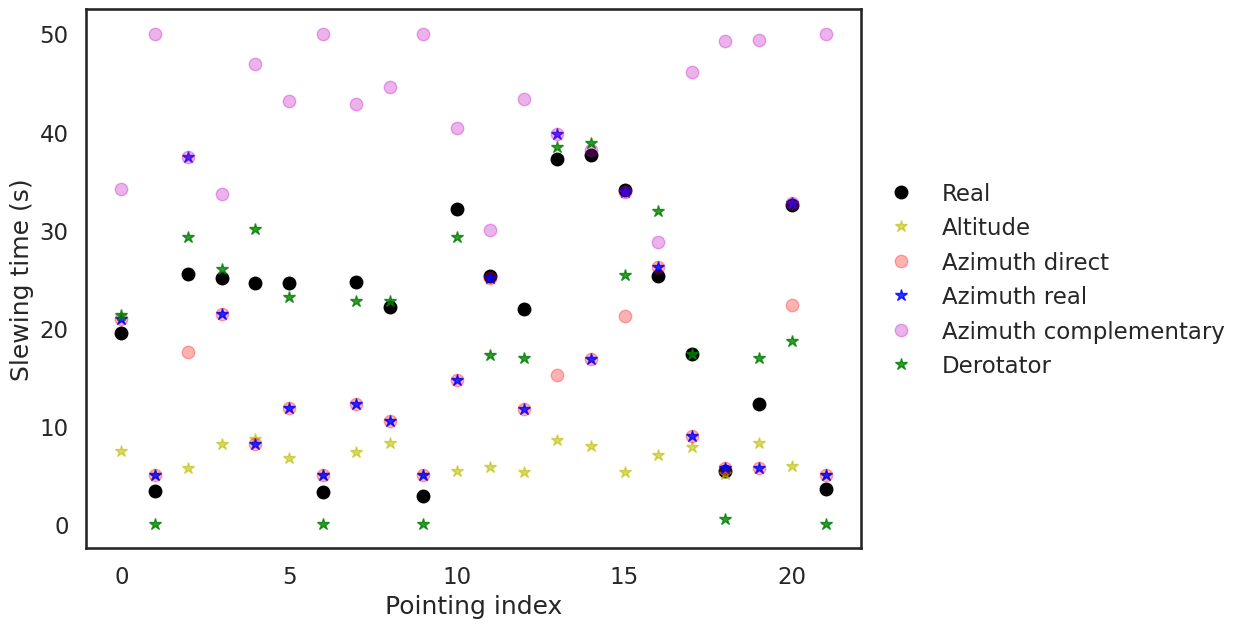

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
x = df_times.index#np.arange(len(df_times))
plt.plot(x, df_times.slewing_time, 'ko', label='Real')

al_v = 8
az_v = 8
rot_v_f = 5.5
rot_v_s = 2.6
al_0 = 5
az_0 = 5
rot_0 = 0

s_al, s_az, s_az_c = mount_slew_time(df_times.dist_alt.to_numpy(), df_times.dist_az.to_numpy(), al_v, az_v, al_0, az_0)
_, s_az_real, _ = mount_slew_time(df_times.dist_alt.to_numpy(), df_times.dist_az_real.to_numpy(), al_v, az_v, al_0, az_0)
s_rot = derotator_time(df_times.dist_rot.to_numpy(), rot_v_f, rot_v_s, rot_0, df_times.change_rot.to_numpy())


plt.plot(x, s_al, 'y*', label='Altitude', alpha=0.6)
plt.plot(x, s_az, 'ro', label='Azimuth direct', alpha=0.3)
plt.plot(x, s_az_real, 'b*', label='Azimuth real', alpha=0.8)
plt.plot(x, s_az_c, 'mo', label='Azimuth complementary', alpha=0.3)
plt.plot(x, s_rot, 'g*', label='Derotator', alpha=0.8)
plt.ylabel('Slewing time (s)')
plt.xlabel('Pointing index')
plt.minorticks_on()
plt.legend(frameon=False, loc=(1.01, 0.3))

plt.show()

## Querying and Processing the Complete Dataset

The provided code is designed to fetch and process telescope operation data over a specified period, spanning from April 20, 2023, to September 23, 2023. By querying daily logs from an ElasticSearch database, the script aggregates the necessary data, computes relevant metrics, and appends it to a master dataframe. Special attention is given to ensuring data integrity, and exceptions, like timeouts, are handled gracefully. The result is a comprehensive dataset that offers insights into the telescope's daily operations and behaviors over several months.

In [ ]:
import warnings

warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

initial_date = '2023-04-20T18:00:00'
final_date = '2023-09-23T18:00:00'

data_range = pd.date_range(initial_date, final_date, freq='1D')
DF = pd.DataFrame()
for n in range(len(data_range)):
    print(data_range[n].strftime('%Y-%m-%d'))
    try:
        df = query_telescope_logs(telescope, data_range[n].strftime('%Y-%m-%dT%H:%M:%S'), data_range[n+1].strftime('%Y-%m-%dT%H:%M:%S'))
        df_times = get_info_from_log(df)
        df_times = add_cable_rotation(df_times)
        ## Check if no rows are missing
        rows = np.round((df_times.prev_az - df_times.prev_cable_rot) % 360,1)
        dd = np.where(rows != 180 or df_times.slewing_time > 60)
        if len(dd[0]) > 0:
            df_times = df_times.iloc[:dd[0][0]]
        if len(df_times) == 0:
            print(' - No valid data')
            continue
        df_times = add_derotator(df_times)
        DF = DF.append(df_times)
        print(' - %i points added' % len(df_times))
    except:
        print(' - Timeout')

2023-04-20
 - 198 points added
2023-04-21
 - 106 points added
2023-04-22
 - 116 points added
2023-04-23
 - Timeout
2023-04-24
 - 183 points added
2023-04-25
 - 154 points added
2023-04-26
 - 120 points added
2023-04-27
 - 1 points added
2023-04-28
 - Timeout
2023-04-29
 - 37 points added
2023-04-30
 - 155 points added
2023-05-01
 - 28 points added
2023-05-02
 - 36 points added
2023-05-03
 - Timeout
2023-05-04
 - 31 points added
2023-05-05
 - 14 points added
2023-05-06
 - Timeout
2023-05-07
 - Timeout
2023-05-08
 - 8 points added
2023-05-09
 - Timeout
2023-05-10
 - 37 points added
2023-05-11
 - 40 points added
2023-05-12
 - 53 points added
2023-05-13
 - 166 points added
2023-05-14
 - 157 points added
2023-05-15
 - 68 points added
2023-05-16
 - 79 points added
2023-05-17
 - 77 points added
2023-05-18
 - 58 points added
2023-05-19
 - 71 points added
2023-05-20
 - 76 points added
2023-05-21
 - 87 points added
2023-05-22
 - 20 points added
2023-05-23
 - 94 points added
2023-05-24
 - 85 poin

In [ ]:
# DF = DF.loc[DF.slewing_time < 60].reset_index(drop=True)
# DF.to_csv('Overheads_TTT1.csv', index=False)
DF = pd.read_csv('Overheads_TTT1.csv')
DF['OB_start_time'] = pd.to_datetime(DF['OB_start_time'])

In [ ]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5872 entries, 0 to 5871
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   OB_start_time       5872 non-null   datetime64[ns, UTC]
 1   total_overhead      5872 non-null   float64            
 2   slewing_time        5872 non-null   float64            
 3   first_frame_time    5872 non-null   float64            
 4   filter_change_time  5872 non-null   float64            
 5   actual_ra           5872 non-null   float64            
 6   actual_dec          5872 non-null   float64            
 7   prev_filter_pos     5869 non-null   float64            
 8   actual_filter_pos   5869 non-null   float64            
 9   actual_alt          5872 non-null   float64            
 10  actual_az           5872 non-null   float64            
 11  prev_dec            5872 non-null   float64            
 12  prev_alt            5872 non-null 

### Optimizing Telescope Operation Parameters Using MCMC

Using the comprehensive dats set we aim to optimize specific parameters of telescope operations using the Markov Chain Monte Carlo (MCMC) method. **Markov Chain Monte Carlo (MCMC)** is a powerful statistical technique used for estimating the distribution of parameters given a set of observations. This method is particularly useful when the parameter space is high-dimensional.

Here's a brief overview of the optimization process:

- **Priors**: Gaussian priors are defined based on the mean values (`prior_means`) for each parameter. These priors incorporate prior knowledge from the example night fitted manually before.

- **Likelihood Function (`log_likelihood`)**: Represents how well our model fits the actual data. It computes the residuals between the predicted and observed slew times and evaluates the likelihood of the parameters given these residuals.

- **Probability Function (`log_probability`)**: Combines the priors and the likelihood to evaluate the overall probability of a set of parameters.

- **MCMC Sampling**: The `emcee` library is utilized to perform the MCMC sampling. Multiple "walkers" explore the parameter space, and over iterations, converge to the areas of highest probability. The `sampler` object collects these samples.

- **Results**: After running the MCMC sampler, the chain of samples is collected, with a specific number of samples discarded as the "burn-in" period. The remaining samples represent the posterior distribution of the parameters.

In [ ]:
import emcee

X = DF[['dist_alt', 'dist_az_real', 'dist_rot','change_rot']].values
y_real = DF['slewing_time'].values


def slewtime(x, alt_v, az_v, rot_v_f, rot_v_s, alt_0, az_0, rot_0):
    dist_alt = np.array(x[:,0])
    dist_az = np.array(x[:,1])
    dist_rot = np.array(x[:,2])
    rot_change = np.array(x[:,3]).astype(bool)
    time_alt = alt_0 + dist_alt / alt_v
    time_az = az_0 + dist_az / az_v

    dist = dist_rot.copy()
    dist[rot_change] = 180 - dist_rot[rot_change]
    v = np.ones(len(dist)) * rot_v_s
    v[rot_change] = rot_v_f
    time_rot = rot_0 + dist / v

    return np.maximum.reduce([time_alt, time_az, time_rot])

In [ ]:
# Gaussian priors
prior_means = {
    'alt_v': 6,
    'az_v': 8,
    'rot_v_f': 5.5,
    'rot_v_s': 2.6,
    'alt_0': 4,
    'az_0': 4,
    'rot_0': 4
}

prior_stds = {key: 0.1 * value for key, value in prior_means.items()}

def log_prior(params):
    alt_v, az_v, rot_v_f, rot_v_s, alt_0, az_0, rot_0 = params
    return (-0.5 * ((alt_v - prior_means['alt_v'])**2 / prior_stds['alt_v']**2 +
                    (az_v - prior_means['az_v'])**2 / prior_stds['az_v']**2 +
                    (rot_v_f - prior_means['rot_v_f'])**2 / prior_stds['rot_v_f']**2 +
                    (rot_v_s - prior_means['rot_v_s'])**2 / prior_stds['rot_v_s']**2 +
                    (alt_0 - prior_means['alt_0'])**2 / prior_stds['alt_0']**2 +
                    (az_0 - prior_means['az_0'])**2 / prior_stds['az_0']**2 +
                    (rot_0 - prior_means['rot_0'])**2 / prior_stds['rot_0']**2))

# def log_likelihood(params):
#     y_pred = slewtime(X, *params)
#     return -0.5 * np.sum((y_pred - y_real)**2)

def log_likelihood(params):
    y_pred = slewtime(X, *params)
    residuals = y_pred - y_real
    sigma2 = np.var(residuals)
    log_likelihood_value = -0.5 * len(y_real) * np.log(2 * np.pi * sigma2) - np.sum(residuals**2) / (2 * sigma2)
    return log_likelihood_value

def log_probability(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params)


# walkers
n_walkers = 32
n_dim = 7
initial_positions = np.array([prior_means['alt_v'], prior_means['az_v'], prior_means['rot_v_f'], prior_means['rot_v_s'], prior_means['alt_0'], prior_means['az_0'], prior_means['rot_0']])
initial_positions = initial_positions + 0.1 * np.random.randn(n_walkers, n_dim)

#  mcmc
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability)
sampler.run_mcmc(initial_positions, 5000, progress=True)
samples = sampler.get_chain(discard=1000, thin=15, flat=True)



100%|██████████| 5000/5000 [07:39<00:00, 10.87it/s]


By analyzing the posterior samples, one can derive insights into the most likely values for the parameters and their uncertainties. In the following corner plot, percentiles 50 and 90 are shown as vertical lines. All parameters show a compact distribution centered on the parameter value.

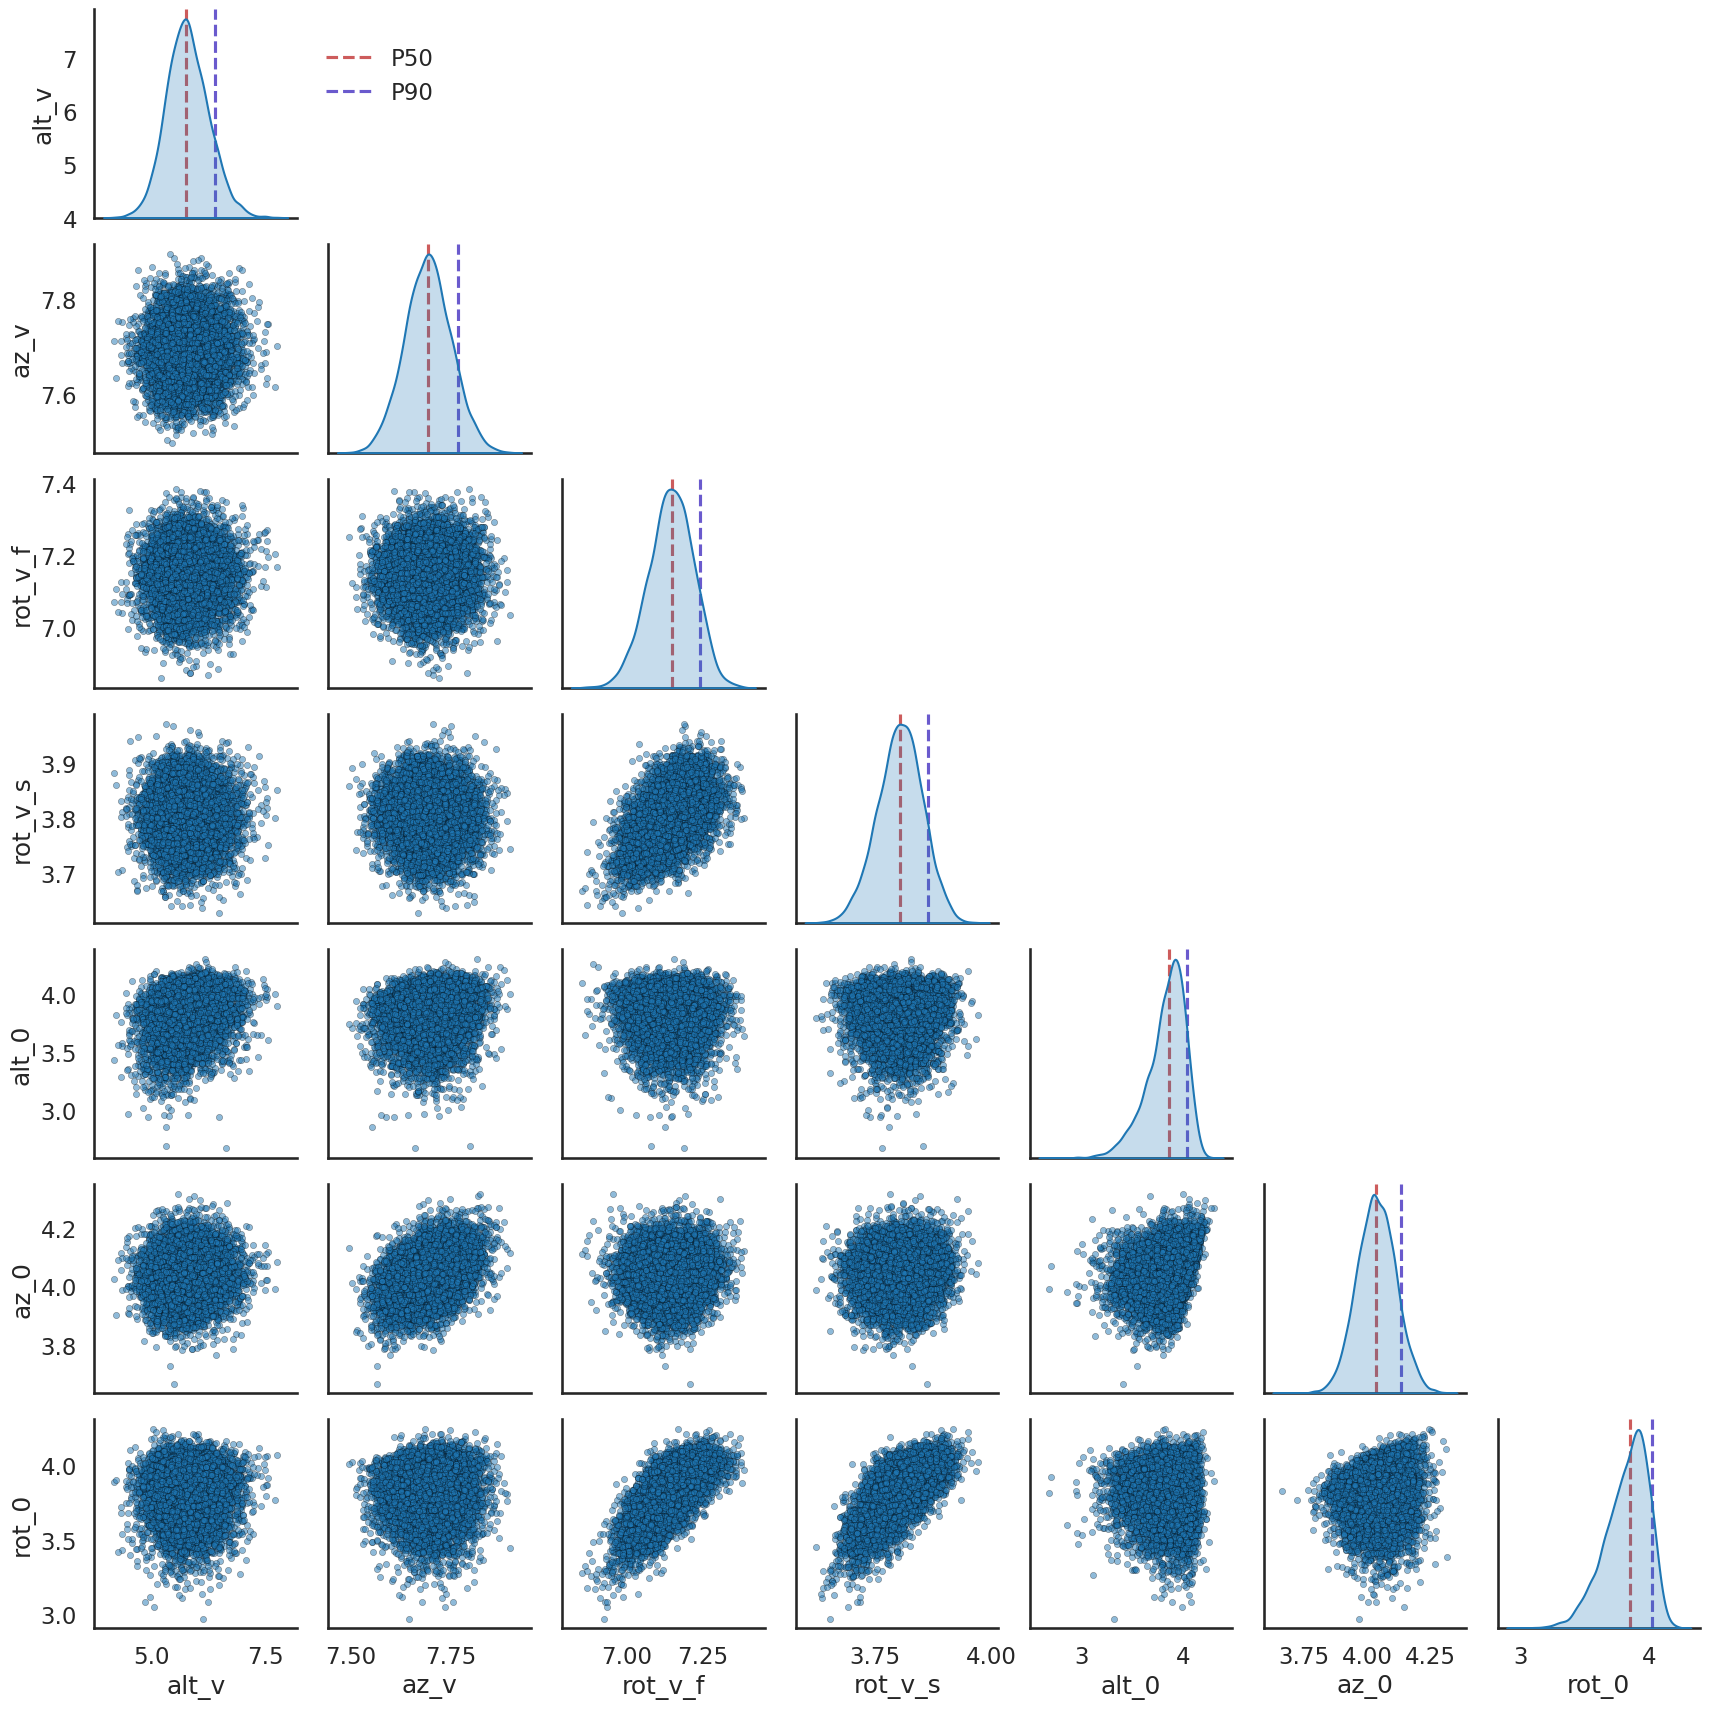

In [ ]:
import seaborn as sns

samples_df = pd.DataFrame(samples, columns=["alt_v", "az_v", "rot_v_f", "rot_v_s", "alt_0", "az_0", "rot_0"])
sns.set_style("white")
sns.set_context("talk")

g = sns.pairplot(samples_df, diag_kind='kde', plot_kws={'alpha': 0.5, 's': 20, 'edgecolor': 'k'}, diag_kws={'fill': True})

for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

for i, col in enumerate(samples_df.columns):
    p50 = np.percentile(samples_df[col], 50)
    p90 = np.percentile(samples_df[col], 90)
    g.axes[i, i].axvline(p50, color='indianred', linestyle='--', label='P50')
    g.axes[i, i].axvline(p90, color='slateblue', linestyle='--', label='P90')


g.axes[0, 0].legend(loc=(1.1, 0.5), frameon=False)


Let's see the distribution of deviations from the real slewing time. For doing that, we select the parameters so the predicted time is systematically overestimated. By doing that, we guarantee that the Observing Blocks are not lost because of delays on telescope movements.

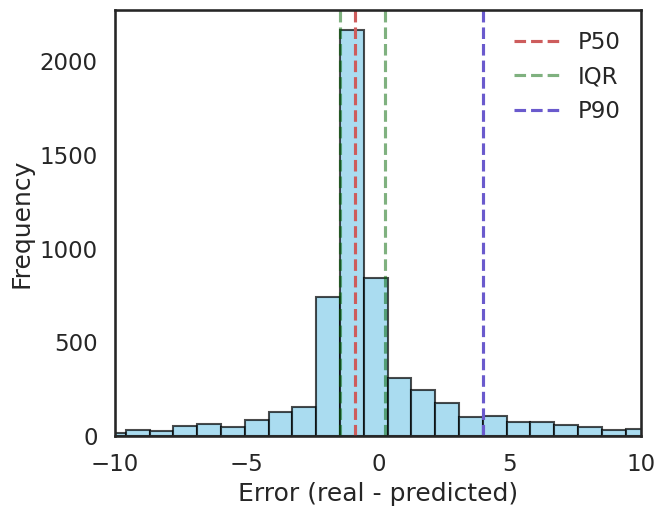

In [ ]:
params = np.zeros(7)
params[:4] = np.percentile(samples[:,:4], 10, axis=0)
params[4:] = np.percentile(samples[:,4:], 90, axis=0)

#params = np.array([5.5, 7.2, 5.2, 2.6, 4, 4, 4])

# Add more idle time
predicted_values = slewtime(X, *params)
errors =  y_real - predicted_values

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5.5))
plt.hist(errors, bins=100, color='skyblue', edgecolor='k', alpha=0.7)
plt.axvline(np.percentile(errors, 50), color='indianred', linestyle='--', label='P50')
plt.axvline(np.percentile(errors, 25), color='darkgreen', linestyle='--', label=None, alpha=0.5)
plt.axvline(np.percentile(errors, 75), color='darkgreen', linestyle='--', label='IQR' , alpha=0.5)
plt.axvline(np.percentile(errors, 90), color='slateblue', linestyle='--', label='P90')

plt.xlabel('Error (real - predicted)')
plt.ylabel('Frequency')
plt.legend(frameon=False)
plt.xlim(-10, 10)
plt.minorticks_on()
plt.tight_layout()
plt.show()

It can be seen that the percentil 50 is centered pon -1.5 seconds, meaning that 50% of the observations start -1.5 seconds before scheduled. The interquartile interval (ICR) is shown in green lines. The error distribution is centainly very close to 0 seconds, so the method presented here is considered to be accurate.

### Evaluating Telescope Operation for a Single Night

After defining the final parameters from the MCMC optimization, another night is showed to verify that it is working properly

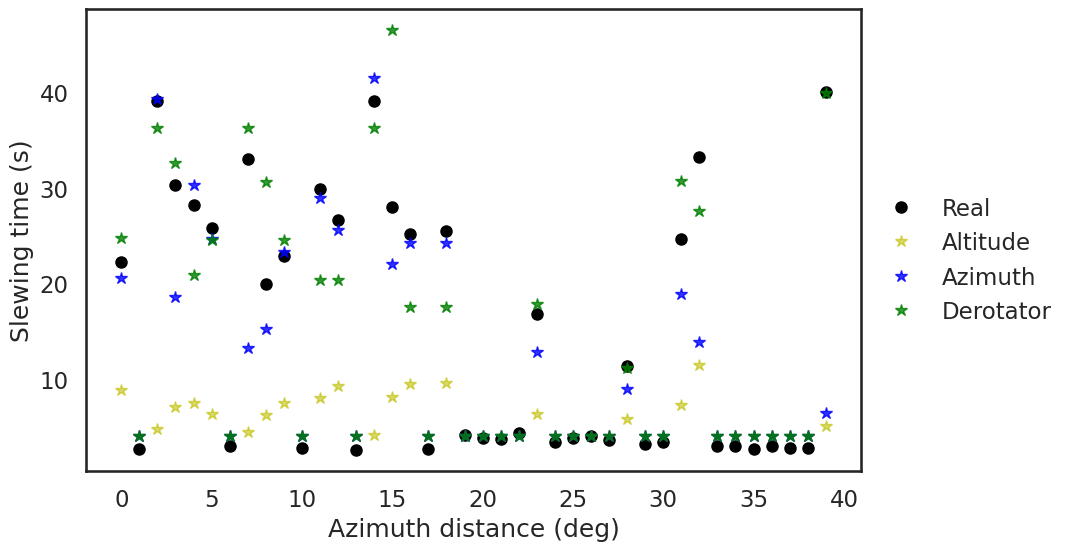

In [ ]:
# select one night
night = '2023-08-15'
night_start = pd.to_datetime(night).tz_localize('UTC') + pd.Timedelta(hours=18)
night_end = pd.to_datetime(night).tz_localize('UTC') + pd.Timedelta(hours=30)
df_night = DF[(DF.OB_start_time > night_start) & (DF.OB_start_time < night_end)].reset_index(drop=True)


params = np.array([8, 7.6, 5.5, 2.6, 4, 4, 4])
params = np.array([5.5, 7.9, 5., 2.2, 4, 4, 4])

plt.figure(figsize=(10, 6))
x = df_night.index
plt.plot(x, df_night.slewing_time, 'ko', label='Real', markersize=8)

X_night = df_night[['dist_alt', 'dist_az_real', 'dist_rot', 'change_rot']].values
time_alt, time_az, time_rot = eval_time(X_night, *params)
_, s_az, s_az_c = mount_slew_time(df_night.dist_alt.to_numpy(), df_night.dist_az.to_numpy(), *params[:2])


plt.plot(x, time_alt, 'y*', label='Altitude', alpha=0.6)
plt.plot(x, time_az, 'b*', label='Azimuth', alpha=0.8)
plt.plot(x, time_rot, 'g*', label='Derotator', alpha=0.8)
plt.ylabel('Slewing time (s)')
plt.xlabel('Azimuth distance (deg)')
plt.minorticks_on()
plt.legend(frameon=False, loc=(1.01, 0.3))

plt.show()